# Neural Quantum Dynamics Emulator (Part II)

### Scope of this notebook

1. We define the configurations for training.
2. We define the benchmark models.
3. We run training on demo dataset.
4. We show the demo models test results.

In [2]:
# Import libraries
import os
import random
import math
import time
import datetime
import collections
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.animation as animation

from tensorflow import keras
from tensorflow.keras import layers
from matplotlib.animation import FuncAnimation
from optimization import create_optimizer
from IPython.display import HTML
from utils import *

## Section 3: Training Setups

### 3.1 Configurations

The critical model and training settings are provided bellow.

In [4]:
class Config:
    def __init__(self, **kwargs):
        # read/write settings
        self.qdml_tfrecords = "../datasets/demo/tfrecords/*"
        self.model_name = "demo"
        self.models_dir = "../models/"
        self.log_name = None

        # training settings
        self.train_batch = 128
        self.input_frames = 4
        self.input_channels = 2  # 3 for full dataset
        self.output_channels = 2
        self.window_size = 23
        self.dropout_rate = 0.
        self.hidden_size = 46  # 69 for full dataset
        self.num_train_steps = 300000 # 5290000 for full dataset

        # optimization
        self.learning_rate = 1e-3
        self.lr_decay_power = 1.0
        self.weight_decay_rate = 0.01
        self.num_warmup_steps = 3000 # 52900 for full dataset
        self.opt_beta_1 = 0.9
        self.opt_beta_2 = 0.999
        self.end_lr = 1e-6
        self.clip_norm = 1.0

        # misc
        self.num_threads = 4
        self.seed = 711
        self.logging_steps = 1000
        self.save_ckpt_steps = 1000000

        self.update(kwargs)        
        self.model_dir = os.path.join(self.models_dir, self.model_name)
        self.log_dir = os.path.join(self.model_dir, "logs")
        self.ckpts = os.path.join(self.model_dir, "ckpts")
    
    def update(self, kwargs):
        for k, v in kwargs.items():
            if v is not None:
                self.__dict__[k] = v

config = Config()

### 3.1 Load dataset

Here we load the windowed-dataset generated from last notebook. In this code snippet, we generate a tensorflow dataset with shuffled and batched training data.

In [5]:
def get_dataset(config, num_cpu_threads=4, world_size=1, rank=0):
    seed = config.seed
    qdml_tfrecords = config.qdml_tfrecords
    batch_size = config.train_batch

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        example = tf.io.parse_single_example(record, name_to_features)
        example = tf.reshape(example["feature"], (config.input_frames + 1, config.window_size, 3))
        return example[:-1, :, :config.input_channels], example[-1, :, :config.output_channels]

    name_to_features = {
        "feature": tf.io.FixedLenFeature([np.product((config.input_frames + 1, config.window_size, 3))], tf.float32),
    }

    input_files = []
    for input_pattern in qdml_tfrecords.split(","):
        input_files.extend(tf.io.gfile.glob(input_pattern))

    d = tf.data.Dataset.from_tensor_slices(tf.constant(input_files))
    d = d.shard(num_shards=world_size, index=rank)
    d = d.repeat()
    d = d.shuffle(buffer_size=len(input_files), seed=seed, reshuffle_each_iteration=True)

    cycle_length = min(num_cpu_threads, len(input_files))
    d = d.interleave(
        tf.data.TFRecordDataset,
        cycle_length=cycle_length,
#         deterministic=False,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    d = d.shuffle(buffer_size=5000, seed=seed, reshuffle_each_iteration=True)

    d = d.map(lambda record: _decode_record(record, name_to_features), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    d = d.batch(batch_size)

    return d

dataset = iter(get_dataset(config, config.num_threads))

All shapes are: (batch, (time_steps,) window_size, channels)
Inputs shape: (128, 4, 23, 3)
labels shape: (128, 23, 2)


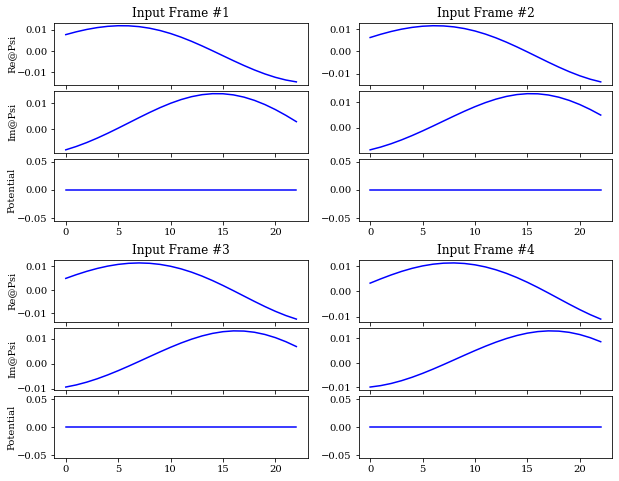

In [117]:
"""Visulize training data"""

def build_plot(config, feature):
    plt.style.use('seaborn-pastel')
    fig = plt.figure(figsize=(10, 8))
    outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.2)
    
    ylabel = ["Re@Psi", "Im@Psi", "Potential"]
    for i in range(4):
        inner = gridspec.GridSpecFromSubplotSpec(
            config.input_channels, 1, 
            subplot_spec=outer[i], wspace=0.1, hspace=0.1)
        
        for j in range(config.input_channels):
            ax = plt.Subplot(fig, inner[j])
            x = np.arange(feature.shape[1])
            y = feature[i, :, j]
            ax.plot(y, c="blue")
            if j == 0:
                ax.set_title(f"Input Frame #{i+1}")
            if i % 2 == 0:
                ax.set_ylabel(ylabel[j])
                ax.yaxis.set_label_coords(-0.15, 0.5)
            fig.add_subplot(ax)

    plt.show()

config = Config(input_channels=3)
dataset = iter(get_dataset(config, config.num_threads))
batch_feature, batch_target = next(dataset)
print('All shapes are: (batch, (time_steps,) window_size, channels)')
print(f'Inputs shape: {batch_feature.shape}')
print(f'labels shape: {batch_target.shape}')
build_plot(config, batch_feature[2])

## Section 4: Models

The minimal trainable model we can apply to this task is to insert linear transformation between the input and output. In this case, we choose to let the output only depend on the last timestep. This model is treated as the baseline model.

In [4]:
class LinearModel(tf.keras.Model):
    def __init__(self, config):
        super().__init__()
        self.last = layers.Lambda(lambda x: x[:, -1, :])
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(config.window_size * config.output_channels)
        self.reshape = layers.Reshape((config.window_size, config.output_channels))

    def call(self, input_tensor, training=False):
        x = self.last(input_tensor)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.reshape(x)

        return x

conf_lin = Config(model_name="demo-lin")
m_lin = LinearModel(conf_lin)
m_lin.build((None, conf_lin.input_frames, conf_lin.window_size, conf_lin.input_channels))
m_lin.summary()

Model: "linear_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              multiple                  0         
_________________________________________________________________
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  3220      
_________________________________________________________________
reshape (Reshape)            multiple                  0         
Total params: 3,220
Trainable params: 3,220
Non-trainable params: 0
_________________________________________________________________


We stack more linear layers to check the performance of a deeper and more expressive model. Moreover, the model takes multiple timesteps to see how the features change overtime before making predictions. ReLU activation function is used to introduce some non-linearities. 

In [5]:
class DenseModel(tf.keras.Model):
    def __init__(self, config):
        super().__init__()
        self.flatten = layers.Reshape((config.input_frames, config.window_size * config.input_channels))
        self.dense1 = layers.Dense(config.hidden_size, activation="relu")
        # conv1d equivlent to a dense layer here
        self.conv1d = layers.Conv1D(filters=config.hidden_size, kernel_size=(config.input_frames), activation='relu')
        self.dense2 = layers.Dense(config.window_size * config.output_channels)
        self.reshape = layers.Reshape((config.window_size, config.output_channels))

    def call(self, input_tensor, training=False):
        x = self.flatten(input_tensor)
        x = self.dense1(x)
        x = self.conv1d(x)
        x = self.dense2(x)
        x = self.reshape(x)
        return x


conf_dense = Config(model_name="demo-dense")
m_dense = DenseModel(conf_dense)
m_dense.build((None, conf_dense.input_frames, conf_dense.window_size, conf_dense.input_channels))
m_dense.summary()

Model: "dense_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  19113     
_________________________________________________________________
dense_2 (Dense)              multiple                  4830      
_________________________________________________________________
dense_3 (Dense)              multiple                  3220      
_________________________________________________________________
reshape_1 (Reshape)          multiple                  0         
Total params: 27,163
Trainable params: 27,163
Non-trainable params: 0
_________________________________________________________________


A convolution layer can also take multiple time steps as input to make a prediction.

In [7]:
class CNNModel(tf.keras.Model):
    def __init__(self, config):
        super().__init__()
        self.flatten = layers.Flatten()
        self.conv1d =layers.Conv2D(filters=16, kernel_size=(config.input_frames, 1), activation='relu')
        self.dense1 = layers.Dense(config.hidden_size, activation="relu")
        self.dense2 = layers.Dense(config.window_size * config.output_channels)
        self.reshape = layers.Reshape((config.window_size, config.output_channels))

    def call(self, input_tensor, training=False):
        x = self.conv1d(input_tensor)
        x = self.flatten(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.reshape(x)
        return x
    
conf_conv = Config(model_name="demo-conv", input_channels=2, hidden_size=46)
m_conv = CNNModel(conf_conv)
m_conv.build((None, conf_conv.input_frames, conf_conv.window_size, conf_conv.input_channels))
m_conv.summary()

Model: "cnn_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          multiple                  0         
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  144       
_________________________________________________________________
dense_2 (Dense)              multiple                  16974     
_________________________________________________________________
dense_3 (Dense)              multiple                  2162      
_________________________________________________________________
reshape_1 (Reshape)          multiple                  0         
Total params: 19,280
Trainable params: 19,280
Non-trainable params: 0
_________________________________________________________________


A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step by step and maintain an internal state from time-step to time-step. In this model, the recurrent layer warms up its internal state during first few timesteps and only returns the output of the final timestep. 

In [7]:
class RNNModel(tf.keras.Model):
    def __init__(self, config):
        super().__init__()
        self.flatten = layers.Reshape((config.input_frames, config.window_size * config.input_channels))
        self.dense1 = layers.Dense(config.hidden_size, activation="relu")
        self.gru = tf.keras.layers.GRU(config.hidden_size, return_state=True, activation='relu', dropout=config.dropout_rate)
        self.dense2 = layers.Dense(config.window_size * config.output_channels)
        self.reshape = layers.Reshape((config.window_size, config.output_channels))

    def call(self, input_tensor, training=False):
        x = self.flatten(input_tensor)
        x = self.dense1(x)
        output, final_state = self.gru(x, initial_state=None, training=training)
        x = tf.concat((output, final_state), axis=-1)
        x = self.dense2(x)
        x = self.reshape(x)
        return x

conf_gru = Config(model_name="demo-gru")
m_gru = RNNModel(conf_gru)
m_gru.build((None, conf_gru.input_frames, conf_gru.window_size, conf_gru.input_channels))
m_gru.summary()

Model: "rnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          multiple                  0         
_________________________________________________________________
dense_6 (Dense)              multiple                  4830      
_________________________________________________________________
gru (GRU)                    multiple                  28980     
_________________________________________________________________
dense_7 (Dense)              multiple                  6394      
_________________________________________________________________
reshape_5 (Reshape)          multiple                  0         
Total params: 40,204
Trainable params: 40,204
Non-trainable params: 0
_________________________________________________________________


## Section 5: Training

In [10]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))


def get_readable_time(elapsed):
    d, h, m, s = [int(x) for x in time.strftime("%d:%H:%M:%S", time.gmtime(elapsed)).split(':')]
    d -= 1
    return '{:2d}h{:2d}m{:2d}s'.format(24 * d + h, m, s)


def main(config, model):
    @tf.function
    def train_step(feature, target, model, optimizer):
        mse = tf.keras.losses.MeanSquaredError()
        with tf.GradientTape() as tape:
            predict = model(feature, True)
            loss = mse(target, predict)

        gradients = tape.gradient(loss, model.trainable_variables)
        clipped_gradients = [tf.clip_by_norm(g, config.clip_norm) for g in gradients]
        optimizer.apply_gradients(zip(clipped_gradients, model.trainable_variables))
        return loss

    tf.random.set_seed(config.seed)
    
    log_name = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") if config.log_name is None else config.log_name
    train_log_dir = config.log_dir + "/" + log_name
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)

    f = open(train_log_dir + "/" + "config.txt", "w")
    f.write(str(config.__dict__))
    f.close()

    dataset = iter(get_dataset(config, config.num_threads))

    optimizer, lr_schedule = create_optimizer(
        init_lr=config.learning_rate,
        num_train_steps=config.num_train_steps,
        num_warmup_steps=config.num_warmup_steps,
        weight_decay_rate=config.weight_decay_rate,
        power=config.lr_decay_power,
        adam_beta1=config.opt_beta_1,
        adam_beta2=config.opt_beta_2,
        min_lr_ratio=config.end_lr / config.learning_rate)
    tf.config.optimizer.set_jit(True)

    metrics = {"train_loss": tf.keras.metrics.Mean(name="train_loss")}

    step = 0
    start_time = logging_time = time.time()

    while step < config.num_train_steps:
        feature, target = next(dataset)
        loss = train_step(feature, target, model, optimizer)
        metrics["train_loss"].update_state(loss)

        step += 1
        if step % config.logging_steps == 0:
            print("Step: {:6d}, Loss: {:.8f}, Time per logging: {:.2f}s, Elapsed: {:}, ETA: {:}".format(
                step,
                metrics["train_loss"].result(),
                time.time() - logging_time,
                get_readable_time(time.time() - start_time),
                get_readable_time(
                    (time.time() - start_time) / step * (config.num_train_steps - step))
            ), flush=True)
            with train_summary_writer.as_default():
                for k in metrics:
                    tf.summary.scalar(k, metrics[k].result(), step=step)
                    metrics[k].reset_states()
            logging_time = time.time()

        if step % config.save_ckpt_steps == 0 and step != config.num_train_steps:
            model.save_weights(os.path.join(config.ckpts, "step_" + str(step)))
            print("Model weights saved at ", os.path.join(config.ckpts, "step_" + str(step)))

    model.save_weights(os.path.join(config.ckpts, "final_step"))
    print("Model weights saved at ", os.path.join(config.ckpts, "final_step"))

In [12]:
"""Training GRU model for demo dataset"""
conf_gru = Config(model_name="demo-gru")
m_gru = RNNModel(conf_gru)
main(conf_gru, m_gru)


"""Training GRU model for full dataset"""
# conf_gru = Config(model_name="full-gru", input_channels=3, hidden_size=69)
# m_gru = RNNModel(conf_gru)
# main(conf_gru, m_gru)

Step:   1000, Loss: 0.00149870, Time per logging: 23.02s, Elapsed:  0h 0m23s, ETA:  1h16m21s


KeyboardInterrupt: 

## Section 6: Demo Models Test

In [103]:
from utils import retrieve_data, get_result, get_loss, build_anime

def plot_loss(ckpts_list, test_file, pot_scalar=1.0, skip_frames=0, frames=400, normalization=False):
    data = retrieve_data(test_file, pot_scalar)
    for model, ckpt in ckpts_list:
        model.load_weights(ckpt)
        result = get_result(model, config, data, skip_frames, total_frames, normalization=normalization)
        loss = get_loss(config, data, result, skip_frames, total_frames)
        plt.plot(loss, label=ckpt.split('/')[2])
    plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()

In [11]:
ckpts_list = [
    (LinearModel(config), "../models/demo-lin/ckpts/final_step"),
    (DenseModel(config), "../models/demo-dense/ckpts/final_step"),
    (CNNModel(config), "../models/demo-conv/ckpts/final_step"),
    (RNNModel(config), "../models/demo-gru/ckpts/final_step")]

plot_loss(ckpts_list, "../datasets/test/free_random_E0_0.0to9.0_S0_1.0to5.0/X0_48.8_S0_2.4_E0_3.3.txt")

In [36]:
def evaluate(ckpts_list, test_files, pot_scalar=1.0, skip_frames=0, total_frames=400, normalization=False):
    files = []
    for input_pattern in test_files.split(","):
        files.extend(tf.io.gfile.glob(input_pattern))
    files.sort()

    ckpt_names = [x[1].split('/')[-3] for x in ckpts_list]
    
    all_loss = np.zeros((len(ckpts_list), len(files), total_frames))
    all_corr = np.zeros((len(ckpts_list), len(files), total_frames))
    
    start_time = time.time()
    n_processed = 0
    for j, file in enumerate(files):
        data = retrieve_data(file, pot_scalar)
        for i, (model, ckpt) in enumerate(ckpts_list):
            model.load_weights(ckpt)
            result = get_result(model, config, data, skip_frames, total_frames, normalization=normalization)
            loss = get_loss(config, data, result, skip_frames, total_frames)
            all_loss[i, j, :] = loss
            true = data["psi_re"][config.input_frames:config.input_frames+total_frames] + 1j * data["psi_im"][config.input_frames:config.input_frames+total_frames]
            pred = result[:, :, 0].numpy() + 1j * result[:, :, 1].numpy()
            all_corr[i, j, :] = [np.abs(np.correlate(true[i], pred[i]) / (np.linalg.norm(true[i]) * np.linalg.norm(pred[i]))) for i in range(len(true))]
            
            elapsed = time.time() - start_time
            n_processed += 1
            print("Processed {:}/{:} ({:.1f}%), ELAPSED: {:}s, ETA: {:}s, ".format(
                n_processed, 
                len(ckpts_list) * len(files), 100.0 * n_processed / len(ckpts_list) / len(files), 
                int(elapsed),
                int((len(ckpts_list) * len(files) - n_processed) / (n_processed / elapsed)),))    
    np.savez("new-demo-3000.npz", files=files, ckpts=ckpt_names, all_loss=all_loss, all_corr=all_corr)

evaluate(ckpts_list, "../datasets/test/free_random_E0_0.0to9.0_S0_1.0to5.0/*.txt")

Processed 1/48 (2.1%), ELAPSED: 18s, ETA: 891s, 
Processed 2/48 (4.2%), ELAPSED: 38s, ETA: 884s, 
Processed 3/48 (6.2%), ELAPSED: 63s, ETA: 955s, 
Processed 4/48 (8.3%), ELAPSED: 114s, ETA: 1258s, 
Processed 5/48 (10.4%), ELAPSED: 134s, ETA: 1153s, 
Processed 6/48 (12.5%), ELAPSED: 153s, ETA: 1074s, 
Processed 7/48 (14.6%), ELAPSED: 177s, ETA: 1037s, 
Processed 8/48 (16.7%), ELAPSED: 225s, ETA: 1127s, 
Processed 9/48 (18.8%), ELAPSED: 243s, ETA: 1056s, 
Processed 10/48 (20.8%), ELAPSED: 263s, ETA: 1000s, 
Processed 11/48 (22.9%), ELAPSED: 286s, ETA: 965s, 
Processed 12/48 (25.0%), ELAPSED: 353s, ETA: 1061s, 
Processed 13/48 (27.1%), ELAPSED: 373s, ETA: 1004s, 
Processed 14/48 (29.2%), ELAPSED: 392s, ETA: 954s, 
Processed 15/48 (31.2%), ELAPSED: 417s, ETA: 917s, 
Processed 16/48 (33.3%), ELAPSED: 466s, ETA: 933s, 
Processed 17/48 (35.4%), ELAPSED: 485s, ETA: 885s, 
Processed 18/48 (37.5%), ELAPSED: 505s, ETA: 841s, 
Processed 19/48 (39.6%), ELAPSED: 529s, ETA: 808s, 
Processed 20/48 (41

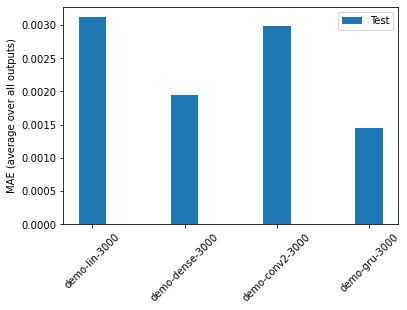

In [9]:
npzfile = np.load("new-demo-3000.npz")

x = np.arange(len(npzfile["ckpts"]))
width = 0.3

all_loss = npzfile["all_loss"]
test_mae = np.mean(all_loss, axis = (1, 2))
# test_std = np.std(np.mean(all_loss, axis = 2), axis = 1)

plt.bar(x, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=npzfile["ckpts"],
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

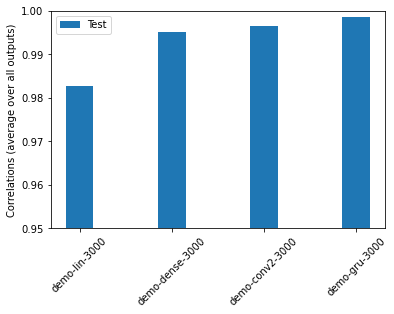

In [12]:
npzfile = np.load("new-demo-3000.npz")

x = np.arange(len(npzfile["ckpts"]))
width = 0.3

all_loss = npzfile["all_corr"]
test_mae = np.mean(all_loss, axis = (1, 2))
# test_std = np.std(np.mean(all_loss, axis = 2), axis = 1)

plt.bar(x, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=npzfile["ckpts"],
           rotation=45)
plt.ylabel('Correlations (average over all outputs)')
plt.ylim(0.95, 1.0)
_ = plt.legend()

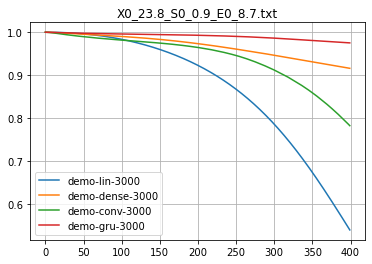

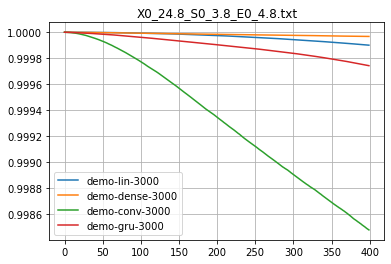

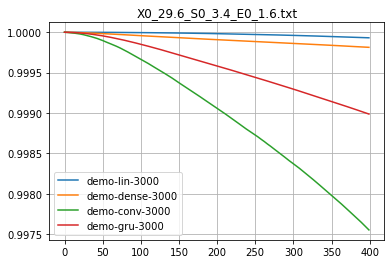

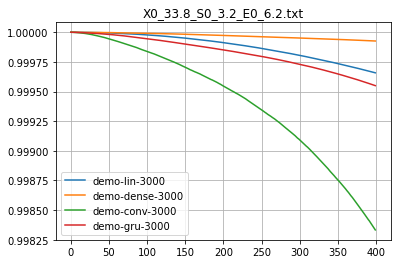

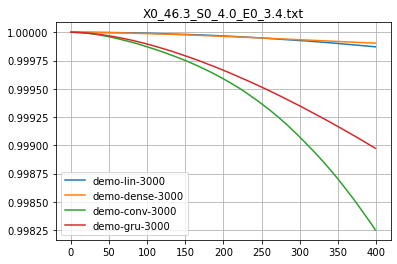

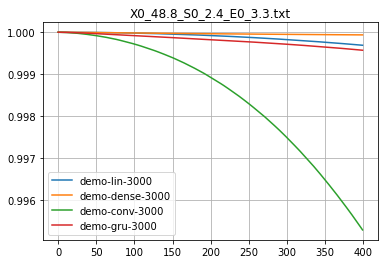

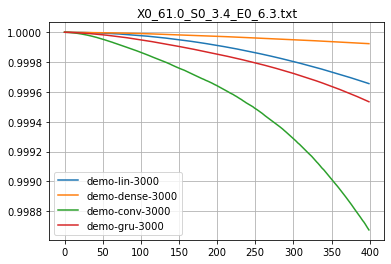

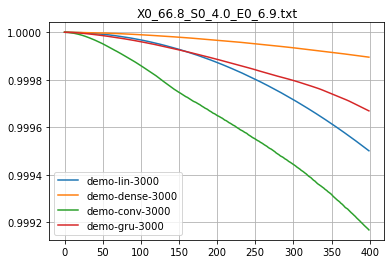

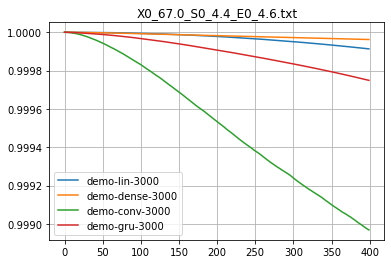

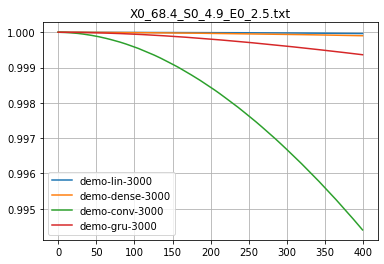

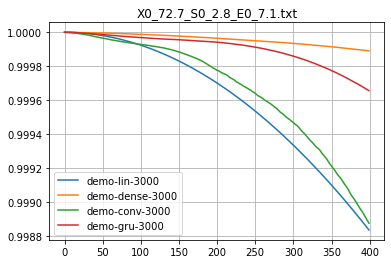

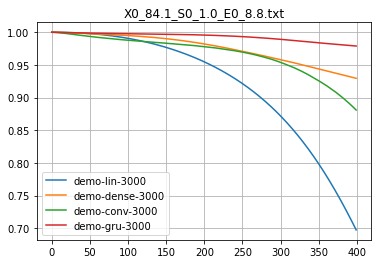

In [63]:
npzfile = np.load("new-demo-3000.npz")
for j, file in enumerate(npzfile["files"]):
    for i, ckpt in enumerate(npzfile["ckpts"][:4]):
        loss = npzfile["all_corr"][i, j, :]
        plt.plot(loss, label=ckpt)
    plt.title(file.split("/")[-1])
#     plt.yscale('log')
    plt.grid(True)
    plt.legend()
    plt.show()